This notebook selected pair-wise C-alpha distances for MSM construction. The selection was based on the following criteria:
1. The distance is smaller than 10 Å (in at least one of the model).
2. The difference (range) of the distance / The mean value is smaller than 0.2.

In [1]:
import MDAnalysis as mda
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from MDAnalysis.lib.distances import distance_array
from MDAnalysis.analysis import distances, align
from MDAnalysis.analysis.distances import dist
import matplotlib.pyplot as plt
import nglview as nv

In [2]:
use_climer = False

In [3]:
#  Load the initial structure of closed, open and desensitized states
u = mda.Universe('../PRODUCTION/BGT_EPJ/SEEDS_0/protein.pdb',
                ['../PRODUCTION/BGT_EPJ/SEEDS_0/protein.pdb',
                 '../PRODUCTION/EPJPNU_EPJ/SEEDS_0/protein.pdb',
                 '../PRODUCTION/EPJ_EPJPNU/SEEDS_0/protein.pdb'])

aligner = align.AlignTraj(u, u, select='protein and name CA', in_memory=True).run()

/nethome/yzhuang/mdanalysis/package/MDAnalysis/coordinates/base.py:724: UserWarning: Reader has no dt information, set to 1.0 ps
  return self.ts.dt
/nethome/yzhuang/mdanalysis/package/MDAnalysis/core/universe.py:645: UserWarning: Reader has no dt information, set to 1.0 ps
  dt=self.trajectory.ts.dt * step,


In [4]:
if use_climer:
    u_climber = mda.Universe('../Climber/TRAJECTORIES/BGT_EPJ/climber.pdb',
                            ['../Climber/TRAJECTORIES/BGT_EPJ/climber.xtc',
                            '../Climber/TRAJECTORIES/BGT_EPJPNU/climber.xtc',
                            '../Climber/TRAJECTORIES/EPJPNU_BGT/climber.xtc',
                            '../Climber/TRAJECTORIES/EPJPNU_EPJ/climber.xtc',
                            '../Climber/TRAJECTORIES/EPJ_BGT/climber.xtc',
                            '../Climber/TRAJECTORIES/EPJ_EPJPNU/climber.xtc'])

    aligner = align.AlignTraj(u_climber, u, select='protein and name CA', in_memory=True).run()

In [5]:
dist_arr_list = []

ca_ag = u.select_atoms('name CA')
for ts in u.trajectory:
    dist_arr = distances.distance_array(ca_ag.positions, # reference
                                        ca_ag.positions, # configuration
                                        box=u.dimensions)
    dist_arr_list.append(dist_arr)
if use_climer:
    ca_ag = u_climber.select_atoms('name CA')
    for ts in u_climber.trajectory:
        dist_arr = distances.distance_array(ca_ag.positions, # reference
                                            ca_ag.positions, # configuration
                                            box=u_climber.dimensions)
        dist_arr_list.append(dist_arr)

In [6]:
pair_wise_indices_list = []
pair_wise_distances_list = []

for dist_arr in tqdm(dist_arr_list, total=len(dist_arr_list)):
    pair_wise_indices = []
    pair_wise_distances = []
    for ind_a1, dist_val in enumerate(dist_arr):
        #  10.0 A is the cutoff distance
        for ind_a2 in np.where(dist_arr[ind_a1] < 10.0)[0]:
            #  2 is the minimum number of residues between the two C-alpha atoms
            if abs(ind_a1 - ind_a2) > 2 and ind_a1 < ind_a2:
                pair_wise_indices.append((ind_a1, ind_a2))
                pair_wise_distances.append(dist_arr[ind_a1, ind_a2])
    pair_wise_indices_list.extend(pair_wise_indices)
    pair_wise_distances_list.extend(pair_wise_distances)

100%|██████████| 3/3 [00:00<00:00, 43.50it/s]


In [7]:
pair_indices_union, pair_indices_union_indx = np.unique(pair_wise_indices_list, return_index=True, axis=0)

pair_indices_union_df = pd.DataFrame(pair_indices_union, columns=['a1', 'a2'])
pair_indices_union_df['a1_chain'] = ca_ag[pair_indices_union_df['a1']].chainIDs
pair_indices_union_df['a2_chain'] = ca_ag[pair_indices_union_df['a2']].chainIDs
pair_indices_union_df['a1_resid'] = ca_ag[pair_indices_union_df['a1']].resids
pair_indices_union_df['a2_resid'] = ca_ag[pair_indices_union_df['a2']].resids
#pair_indices_union_df['distance'] = np.array(pair_wise_distances_list)[pair_indices_union_indx]
pair_indices_union_df.sort_values(by=['a1', 'a2'], inplace=True, ignore_index=True)
#  A and F are the two chains of the same subunit
pair_indices_union_df = pair_indices_union_df[(pair_indices_union_df['a1_chain'] == 'A') | (pair_indices_union_df['a1_chain'] == 'F')]

In [8]:
print(pair_indices_union_df.head())
print(pair_indices_union_df.shape)

   a1  a2 a1_chain a2_chain  a1_resid  a2_resid
0   0   3        A        A         1         4
1   0   4        A        A         1         5
2   0   5        A        A         1         6
3   0  70        A        A         1        71
4   0  71        A        A         1        72
(3649, 6)


In [9]:
pair_indices_union_df.to_pickle('pair_indices_union_df.pickle')

In [10]:
# the corresponding complementary subunit dic

subunit_iter_dic = {'A': 'B',
                    'B': 'C',
                    'C': 'D',
                    'D': 'E',
                    'E': 'A',
                    'F': 'G',
                    'G': 'H',
                    'H': 'I',
                    'I': 'J',
                    'J': 'F'}

In [11]:
#  calculate all distance between the two selected C-alpha atoms
distance_array_frame = []

ag1 = u.atoms[[]]
ag2 = u.atoms[[]]
if use_climer:
    ag1_climber = u_climber.atoms[[]]
    ag2_climber = u_climber.atoms[[]]
for ind, row in pair_indices_union_df.iterrows():
    ag1 += u.select_atoms('name CA and segid {} and resid {}'.format(row.a1_chain, row.a1_resid))
    ag2 += u.select_atoms('name CA and segid {} and resid {}'.format(row.a2_chain, row.a2_resid))
    if use_climer:
        ag1_climber += u_climber.select_atoms('name CA and segid {} and resid {}'.format(row.a1_chain, row.a1_resid))
        ag2_climber += u_climber.select_atoms('name CA and segid {} and resid {}'.format(row.a2_chain, row.a2_resid))

In [12]:
for ts in tqdm(u.trajectory, total=u.trajectory.n_frames):
    distance_array_frame.append(dist(ag1, ag2)[2])

if use_climer:
    for ts in tqdm(u_climber.trajectory, total=u_climber.trajectory.n_frames):
        distance_array_frame.append(dist(ag1_climber, ag2_climber)[2])

100%|██████████| 3/3 [00:00<00:00, 2030.81it/s]


In [13]:
#  calculate the distance difference between different models
#  ptp is the peak-to-peak value (range) of the distance
#  mean is the mean value of the distance

dist_diff = np.asarray(distance_array_frame).T.ptp(axis=1) / np.asarray(distance_array_frame).T.mean(axis=1)

dist_max = np.asarray(distance_array_frame).T.max(axis=1)
dist_min = np.asarray(distance_array_frame).T.min(axis=1)

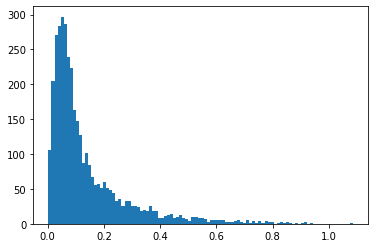

In [14]:
plt.hist(dist_diff, bins=100)
plt.show()

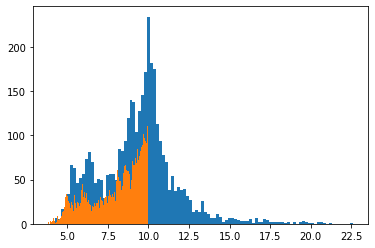

In [15]:
plt.hist(dist_max, bins=100)
plt.hist(dist_min, bins=100)
plt.show()

In [16]:
pair_indices_union_df['distance_max'] = dist_max
pair_indices_union_df['distance_min'] = dist_min

In [17]:
# select the distance difference / mean larger than 0.2
pair_indices_union_df_2diff = pair_indices_union_df[dist_diff > 0.2].reset_index(drop=True)

In [18]:
print(pair_indices_union_df_2diff.head())
print(pair_indices_union_df_2diff.shape)

   a1    a2 a1_chain a2_chain  a1_resid  a2_resid  distance_max  distance_min
0   0  1297        A        E         1        18     10.229564      8.325569
1   0  1298        A        E         1        19     11.287349      9.120897
2   0  1299        A        E         1        20     10.313668      8.078906
3   3  1297        A        E         4        18      6.976122      5.464251
4   4    70        A        A         5        71      9.416890      7.677821
(784, 8)


In [19]:
pair_indices_union_df_2diff['a1_rep'] = pair_indices_union_df_2diff[['a1_resid', 'a1_chain']].apply(lambda x: '{}:{}.CA'.format(x[0], x[1]), axis=1)
pair_indices_union_df_2diff['a2_rep'] = pair_indices_union_df_2diff[['a2_resid', 'a2_chain']].apply(lambda x: '{}:{}.CA'.format(x[0], x[1]), axis=1)

In [33]:
pair_indices_union_df_2diff

,a1,a2,a1_chain,a2_chain,a1_resid,a2_resid,distance_max,distance_min,a1_rep,a2_rep
0,0,1297,A,E,1,18,10.229564,8.325569,1:A.CA,18:E.CA
1,0,1298,A,E,1,19,11.287349,9.120897,1:A.CA,19:E.CA
2,0,1299,A,E,1,20,10.313668,8.078906,1:A.CA,20:E.CA
3,3,1297,A,E,4,18,6.976122,5.464251,4:A.CA,18:E.CA
4,4,70,A,A,5,71,9.416890,7.677821,5:A.CA,71:A.CA
...,...,...,...,...,...,...,...,...,...,...
779,1655,1658,F,F,391,394,9.097362,7.419378,391:F.CA,394:F.CA
780,1655,1660,F,F,391,396,10.298799,8.107979,391:F.CA,396:F.CA
781,1660,1664,F,F,396,400,6.398789,4.990758,396:F.CA,400:F.CA
782,1660,1665,F,F,396,401,8.696835,6.389801,396:F.CA,401:F.CA


In [34]:
u.atoms

<AtomGroup with 31065 atoms>

In [60]:
with open('draw_contact.vmd', 'wt') as f:
    f.writelines('draw materials off\n')
    f.writelines('draw color 15\n')
    for ind, row in pair_indices_union_df_2diff.iterrows():
        atom_1 = u.select_atoms('name CA and segid {} and resid {}'.format(row.a1_chain, row.a1_resid))[0]
        atom_2 = u.select_atoms('name CA and segid {} and resid {}'.format(row.a2_chain, row.a2_resid))[0]
        f.writelines(f'draw line \u007b{atom_1.position[0]:1f} {atom_1.position[1]:1f} {atom_1.position[2]:1f}\u007d \u007b{atom_2.position[0]:1f} {atom_2.position[1]:1f} {atom_2.position[2]:1f}\u007d width 3\n')

In [20]:
#  Show selected distances in NGLView
view = nv.show_mdanalysis(u)
view.add_distance(atom_pair=pair_indices_union_df_2diff[['a1_rep', 'a2_rep']].values,
                  label_color="black")

In [21]:
view

NGLWidget(max_frame=2)

In [24]:
# save the selected distance indices
pair_indices_union_df_2diff.to_pickle('pair_indices_union_df_2div.pickle')

## Plot selected contacts

In [22]:
def next_alpha(s):
    return chr((ord(s.upper())+1 - 65) % 26 + 65)

max_resid_index = 401
contact_matrix_intra = np.zeros((max_resid_index, max_resid_index))
contact_matrix_inter_1 = np.zeros((max_resid_index, max_resid_index))
contact_matrix_inter_2 = np.zeros((max_resid_index, max_resid_index))
for i, row in pair_indices_union_df.iterrows():
    if row.a1_chain == row.a2_chain:
        contact_matrix_intra[row.a1_resid-1, row.a2_resid-1] = 1
        contact_matrix_intra[row.a2_resid-1, row.a1_resid-1] = 1

    elif np.abs(ord(row.a1_chain) - ord(row.a2_chain)) == 5:
        contact_matrix_intra[row.a1_resid-1, row.a2_resid-1] = 1
        contact_matrix_intra[row.a2_resid-1, row.a1_resid-1] = 1

    elif subunit_iter_dic[row.a1_chain] == row.a2_chain:
        contact_matrix_inter_1[row.a1_resid-1, row.a2_resid-1] = 1
    elif subunit_iter_dic[row.a2_chain] == row.a1_chain:
        contact_matrix_inter_2[row.a1_resid-1, row.a2_resid-1] = 1
    else:
        pass
#        print(row)

In [23]:
contact_matrix_intra_2diff = np.zeros((max_resid_index, max_resid_index))
contact_matrix_inter_1_2diff = np.zeros((max_resid_index, max_resid_index))
contact_matrix_inter_2_2diff = np.zeros((max_resid_index, max_resid_index))
for i, row in pair_indices_union_df[dist_diff > 0.2].iterrows():
    if row.a1_chain == row.a2_chain:
        contact_matrix_intra_2diff[row.a1_resid-1, row.a2_resid-1] = 1
        contact_matrix_intra_2diff[row.a2_resid-1, row.a1_resid-1] = 1

    elif np.abs(ord(row.a1_chain) - ord(row.a2_chain)) == 5:
        contact_matrix_intra_2diff[row.a1_resid-1, row.a2_resid-1] = 1
        contact_matrix_intra_2diff[row.a2_resid-1, row.a1_resid-1] = 1

    elif subunit_iter_dic[row.a1_chain] == row.a2_chain:
        contact_matrix_inter_1_2diff[row.a1_resid-1, row.a2_resid-1] = 1
    elif subunit_iter_dic[row.a2_chain] == row.a1_chain:
        contact_matrix_inter_2_2diff[row.a1_resid-1, row.a2_resid-1] = 1
    else:
        pass

In [24]:
domain_annotations_plot = {
                        'L\nb1b2': range(40,50),
                        'L\ncys': range(130,140),
                        'L\nF': range(166,180),

                        'L\nC':range(180,195),
                        'M\n1': range(207,232),
                        'M\n2': range(235,261),
                        'L\n23': range(258,267),

                        'M\n3': range(267,298),
                        'M\nX': range(300,321),
                        'M\nA': range(331,358),
                        'M\n4': range(359,390),
                        'M\nC': range(391,402)}

In [28]:
from scipy.ndimage import maximum_filter
from msm_a7_nachrs.manuscript.manuscript import *

def plot_contact_heatmap(matrix, scatter_matrix, intra, name, cmap='bwr'):
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))

    sns.heatmap(matrix, cmap=cmap, vmax=1, vmin=-1, cbar=False, ax=ax,
                cbar_kws={'orientation': 'vertical', 'fraction': 0.046, 'pad': 0.04, 'label': 'Correlation'})

    if scatter_matrix is not None:
        for i in range(0, scatter_matrix.shape[0]):
            for j in range(0, scatter_matrix.shape[1]):
                if scatter_matrix[i, j] > 0:
                    ax.scatter(j, i, marker='x', color='blue', s=100, linewidth=4)
    ax.set_title(name, fontsize=30)
    if intra:
        ax.set_xlabel('Residue', fontsize=30)
        ax.set_ylabel('Residue', fontsize=30)
    else:
        ax.set_ylabel('Principle (+) Residue', fontsize=30)
        ax.set_xlabel('Complementary (-) Residue', fontsize=30)
#    ax.set_aspect('equal')
    ax.set_xticks([np.mean(domain[1]) for domain in domain_annotations_plot.items()])
    ax.set_xticklabels([domain[0] for domain in domain_annotations_plot.items()], rotation=0)
    ax.xaxis.set_tick_params(size=0)

    ax.set_xlim(1,max_resid_index + 5)

    ax.set_ylim(1,max_resid_index + 5)
    ax.set_yticks([np.mean(domain[1]) for domain in domain_annotations_plot.items()])
    ax.set_yticklabels([domain[0] for domain in domain_annotations_plot.items()], rotation=90)
    ax.yaxis.set_tick_params(size=0)

    set_axis_boarder(ax)
    ax2 = ax.twiny()
    ax2.set_xlabel('')
    ax2.tick_params(axis='x',direction='out')
    ax2.set_xlim(1, max_resid_index + 5)

    ax2.spines['top'].set_linewidth(4)
    ax2.spines['right'].set_linewidth(4)
    ax2.spines['left'].set_linewidth(4)
    ax2.spines['bottom'].set_linewidth(4)
    ax2.set_xticks(np.arange(1, max_resid_index + 5, 50))
    ax2.set_xticklabels(np.arange(1, max_resid_index + 5, 50))

    ax3 = ax.twinx()
    ax3.set_ylabel('')

    ax3.set_yticks(np.arange(1, max_resid_index + 5, 50))
    ax3.set_yticklabels(np.arange(1, max_resid_index + 5, 50))

    ax.hlines([np.min(domain[1]) for domain in domain_annotations_plot.items()], *ax.get_xlim(), color='black', linewidth=2, linestyle='--')
    ax.vlines([np.min(domain[1]) for domain in domain_annotations_plot.items()], *ax.get_ylim(), color='black', linewidth=2, linestyle='--')
#    plt.savefig(f'assets/feature_selection_{name}.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'assets/feature_selection_{name}.pdf', dpi=300, bbox_inches='tight', transparent=True)

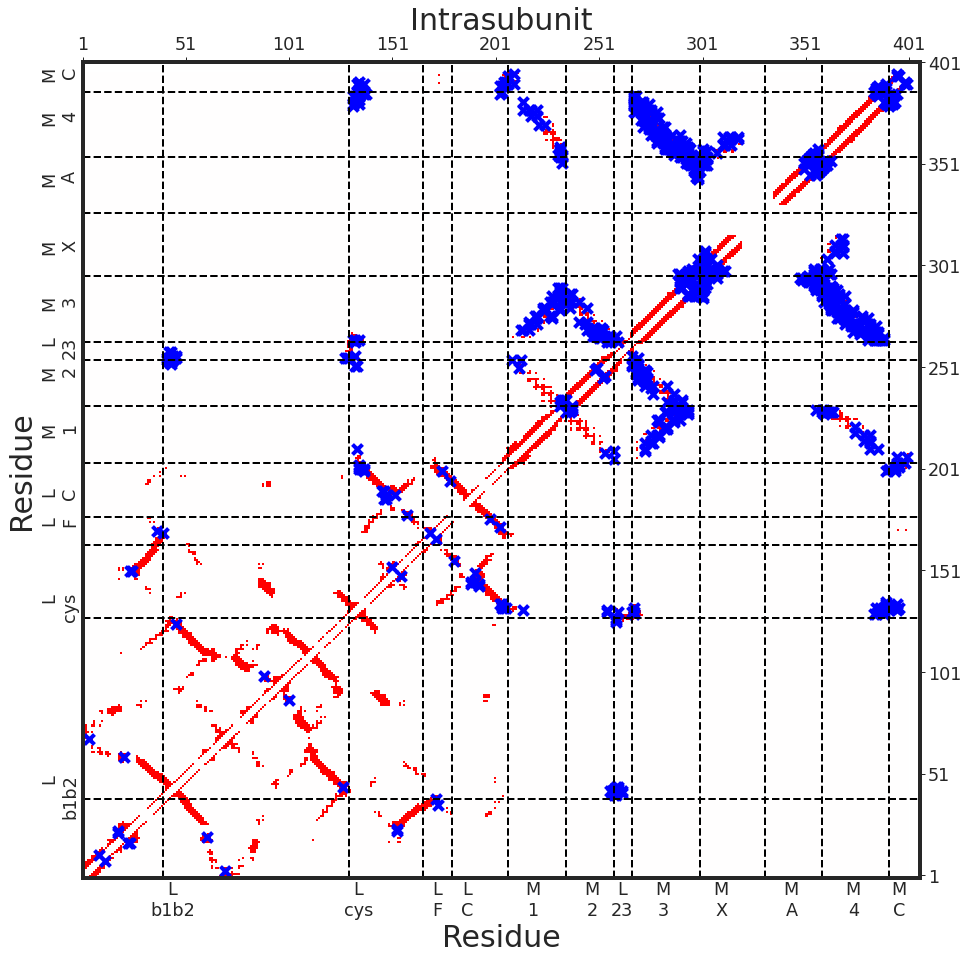

In [29]:
plot_contact_heatmap(matrix=contact_matrix_intra, scatter_matrix=contact_matrix_intra_2diff, intra=True, name='Intrasubunit', cmap='bwr')

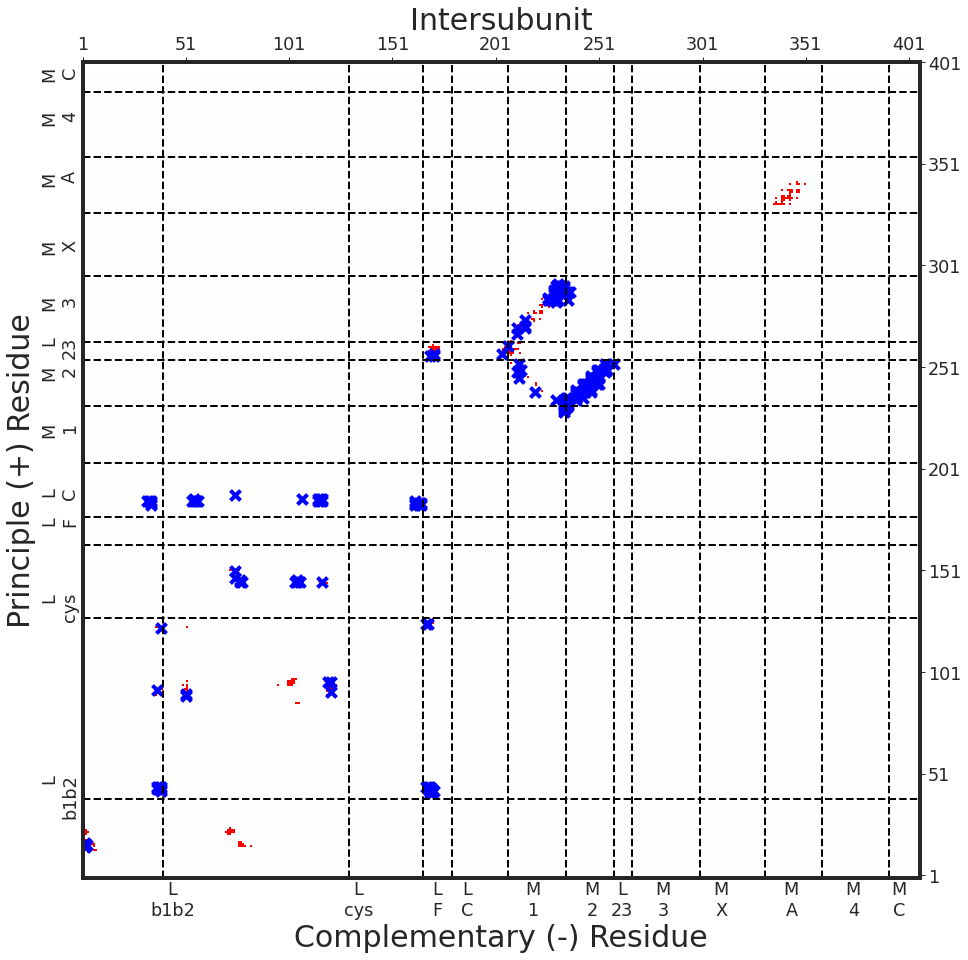

In [30]:
plot_contact_heatmap(contact_matrix_inter_1, contact_matrix_inter_1_2diff, intra=False, name='Intersubunit', cmap='bwr')